# Quant GAN
## Torch Verison
[Wiese et al., Quant GANs: Deep Generation of Financial Time Series, 2019](https://arxiv.org/abs/1907.06673)

In [1]:
import os
import json
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import yfinance as yf
import seaborn as sns
import statsmodels.api as sm
sns.set_style('darkgrid')

from preprocess.utils import *
from model.torch_tcn import *


In [2]:
# List of selected tickers
assets = {
    "^GSPC": 'S&P', # S&P 500 Index
    #"000001.SS": 'SSE' # Shanghai Composite Index (SSE)
}

# Time period (from the paper)
start_date = "2009-05-01"
end_date = "2018-12-01"

# Fetching daily data
all_data = {}
for asset in assets:
    print(f"Downloading data for {asset}...")
    try:
        data = yf.download(asset, start=start_date, end=end_date, interval='1d')
        all_data[asset] = data[['Close']]
    except Exception as e:
        print(f"Could not download data for {asset}: {e}")

# Combine Close prices into a single DataFrame
prices = pd.concat(all_data.values(), axis=1).dropna()
prices.columns = assets.values()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


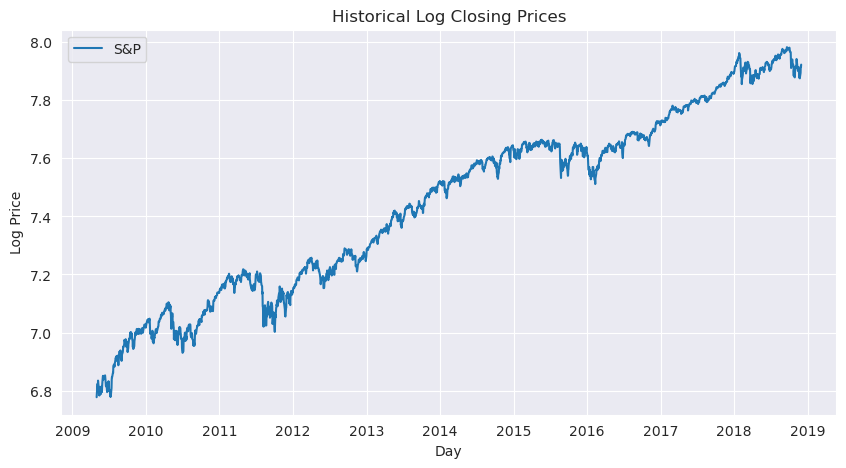

In [3]:
# Plot historical log closing prices
plt.figure(figsize=(10, 5))
plt.plot(prices.index, np.log(prices), label=prices.columns)
plt.title('Historical Log Closing Prices')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Log Price')
plt.grid(True)
plt.show()

## Preprocess data
 For more details see [preprocess.ipynb](./preprocess.ipynb)

In [4]:
log_returns = np.log(prices).diff().dropna()
log_val = log_returns.values
log_norm = log_val - np.mean(log_val)
params = igmm(log_norm)
log_transformed = W_delta((log_norm - params[0]) / params[1], params[2])
log_max = np.max(np.abs(log_transformed))
log_processed = log_transformed / log_max

In [5]:
log_processed = log_processed.flatten()

## Train model
 For more details see [torch_model.ipynb](./torch_model.ipynb)

In [6]:
class LoaderGAN(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = np.expand_dims(self.data[index:index+self.window], -1)
        return torch.from_numpy(x).float()

    def __len__(self):
        return len(self.data) - self.window

In [7]:
# Checkpoints directory
generator_path = 'saved_models/'
os.makedirs(generator_path, exist_ok=True)  

# Hyperparameters
clip_value = 0.01
lr = 0.0002
num_epochs = 100
nz = 3
batch_size = 32
seq_len = 127

# Device
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device(dev)

In [8]:
netG = Generator(nz, 1).to(device)
train = False

if train:
    netD = Discriminator(1, 1).to(device)
    optD = optim.RMSprop(netD.parameters(), lr=lr)
    optG = optim.RMSprop(netG.parameters(), lr=lr)

    dataset = LoaderGAN(log_processed, seq_len)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    t = tqdm(range(num_epochs))

    # Track best epoch and best loss
    best_lossG = float('inf')
    best_epoch = 0
    generator_losses = []

    for epoch in t:
        for i, data in enumerate(dataloader, 0):
            netD.zero_grad()
            real = data.to(device)
            batch_size, seq_len = real.size(0), real.size(1)
            noise = torch.randn(batch_size, seq_len, nz, device=device)
            fake = netG(noise).detach()

            lossD = -torch.mean(netD(real)) + torch.mean(netD(fake))
            lossD.backward()
            optD.step()

            for p in netD.parameters():
                p.data.clamp_(-clip_value, clip_value)

            if i % 5 == 0:
                netG.zero_grad()
                lossG = -torch.mean(netD(netG(noise)))
                lossG.backward()
                optG.step()


        # Save only the best
        if lossG.item() < best_lossG:
            best_lossG = lossG.item()
            best_epoch = epoch
            generator_losses.append(lossG.item())
            torch.save(netG.state_dict(), f'{generator_path}sp500_netG_best.pth')
            torch.save(netD.state_dict(), f'{generator_path}sp500_netD_best.pth')

        t.set_description('Loss_D: %.8f Loss_G: %.8f' % (lossD.item(), lossG.item()))

    # Saving JSON
    with open(f'{generator_path}generator_losses.json', 'w') as f:
        json.dump({
            'generator_losses': generator_losses,
            'best_epoch': best_epoch,
            'best_lossG': best_lossG
        }, f)

    print(f"Best epoch : {best_epoch}, Best Loss_G : {best_lossG}")

else:
    with open(f'{generator_path}generator_losses.json', 'r') as f:
        loss_data = json.load(f)

    best_epoch = loss_data['best_epoch']
    best_lossG = loss_data['best_lossG']
    print(f"Best epoch : {best_epoch}, Best Loss_G : {best_lossG}")

    # Load only the best model
    netG.load_state_dict(torch.load(f'{generator_path}sp500_netG_best.pth', map_location=device))
    netG.eval()
    print(f"Model loaded : sp500_netG_best.pth")


Best epoch : 95, Best Loss_G : -0.5246461629867554
Model loaded : sp500_netG_best.pth


## Generate

/opt/conda/lib/python3.12/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


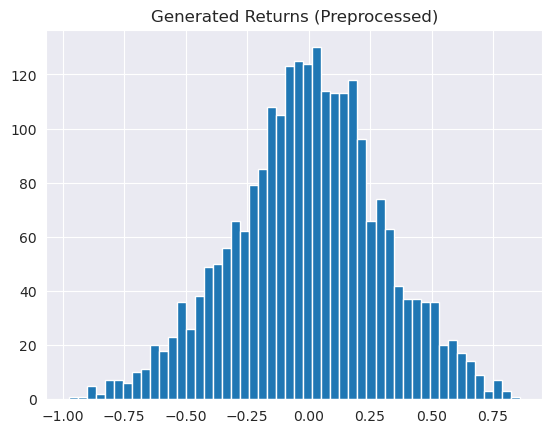

In [9]:
noise = torch.randn(1, len(log_returns), 3, device=device)
fake = netG(noise).detach().cpu().reshape(len(log_returns)).numpy()
plt.hist(fake, bins=50)
plt.title('Generated Returns (Preprocessed)')
plt.show()

In [10]:
log_fake = inverse(fake * log_max, params)

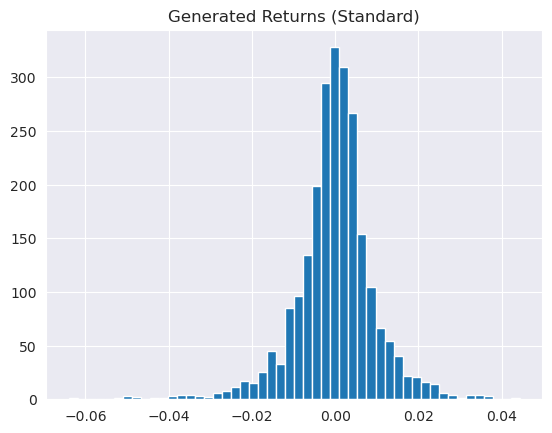

In [11]:
plt.hist(log_fake, bins=50)
plt.title('Generated Returns (Standard)')
plt.show()

In [12]:
def generate_fakes(n: int = 1, cumsum: bool = True):
    fakes = []
    for _ in range(n):
        noise = torch.randn(1, len(log_returns), 3, device=device)
        fake = netG(noise).detach().cpu().reshape(len(log_returns)).numpy()
        log_fake = inverse(fake * log_max, params) + np.mean(log_returns)
        fakes.append(log_fake)
    
    result = pd.DataFrame(fakes).T  # dimension : (len(log_returns), n)
    
    if cumsum:
        result = result.cumsum()
    
    # For n = 1, pd.Series
    if n == 1:
        return result.iloc[:, 0]
    
    return result

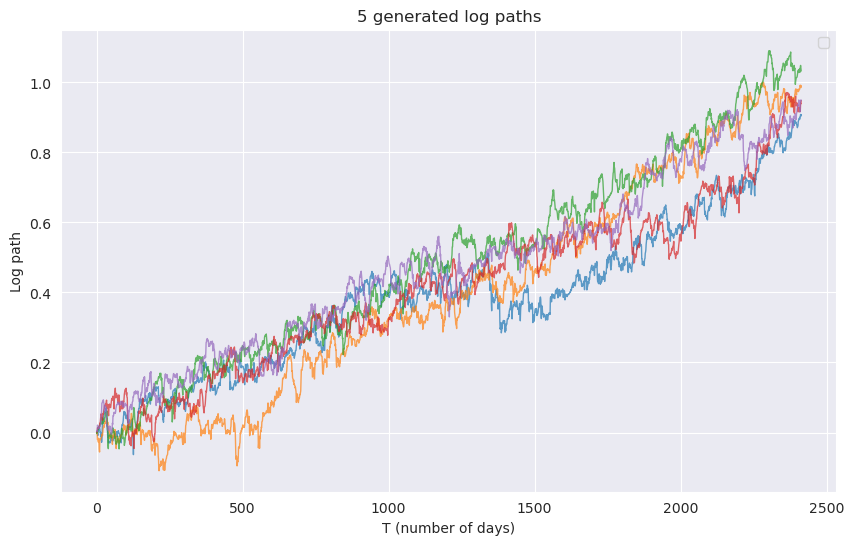

In [13]:
plt.figure(figsize=(10,6))
plt.plot(generate_fakes(5), linewidth=1, alpha=0.7)
plt.legend('')
plt.grid(True)
plt.xlabel('T (number of days)')
plt.ylabel('Log path')
plt.title('5 generated log paths')
plt.show()

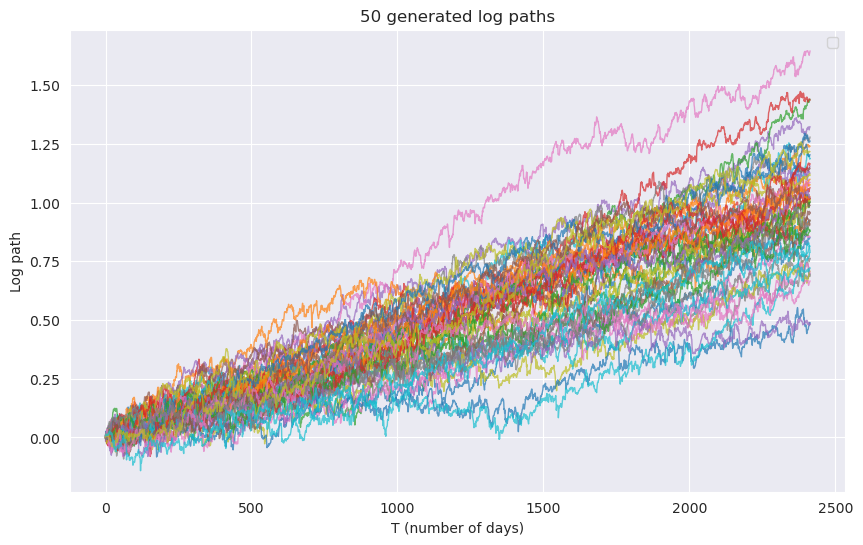

In [14]:
plt.figure(figsize=(10,6))
plt.plot(generate_fakes(50), linewidth=1, alpha=0.7)
plt.legend('')
plt.grid(True)
plt.xlabel('T (number of days)')
plt.ylabel('Log path')
plt.title('50 generated log paths')
plt.show()

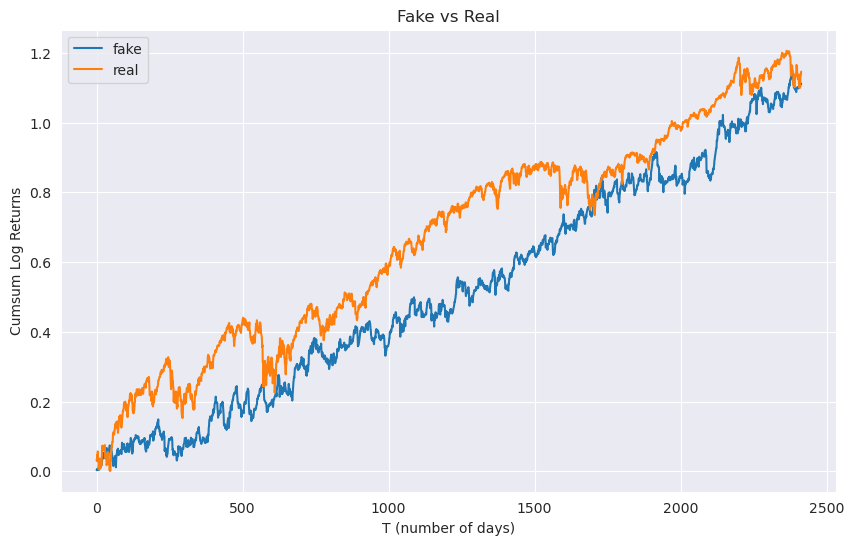

In [15]:
comp_df = pd.DataFrame({'fake': generate_fakes(), 'real': log_val.cumsum()})
ax = comp_df.plot(figsize=(10, 6))
ax.set_title('Fake vs Real')
ax.set_xlabel('T (number of days)')
ax.set_ylabel('Cumsum Log Returns')
plt.show()

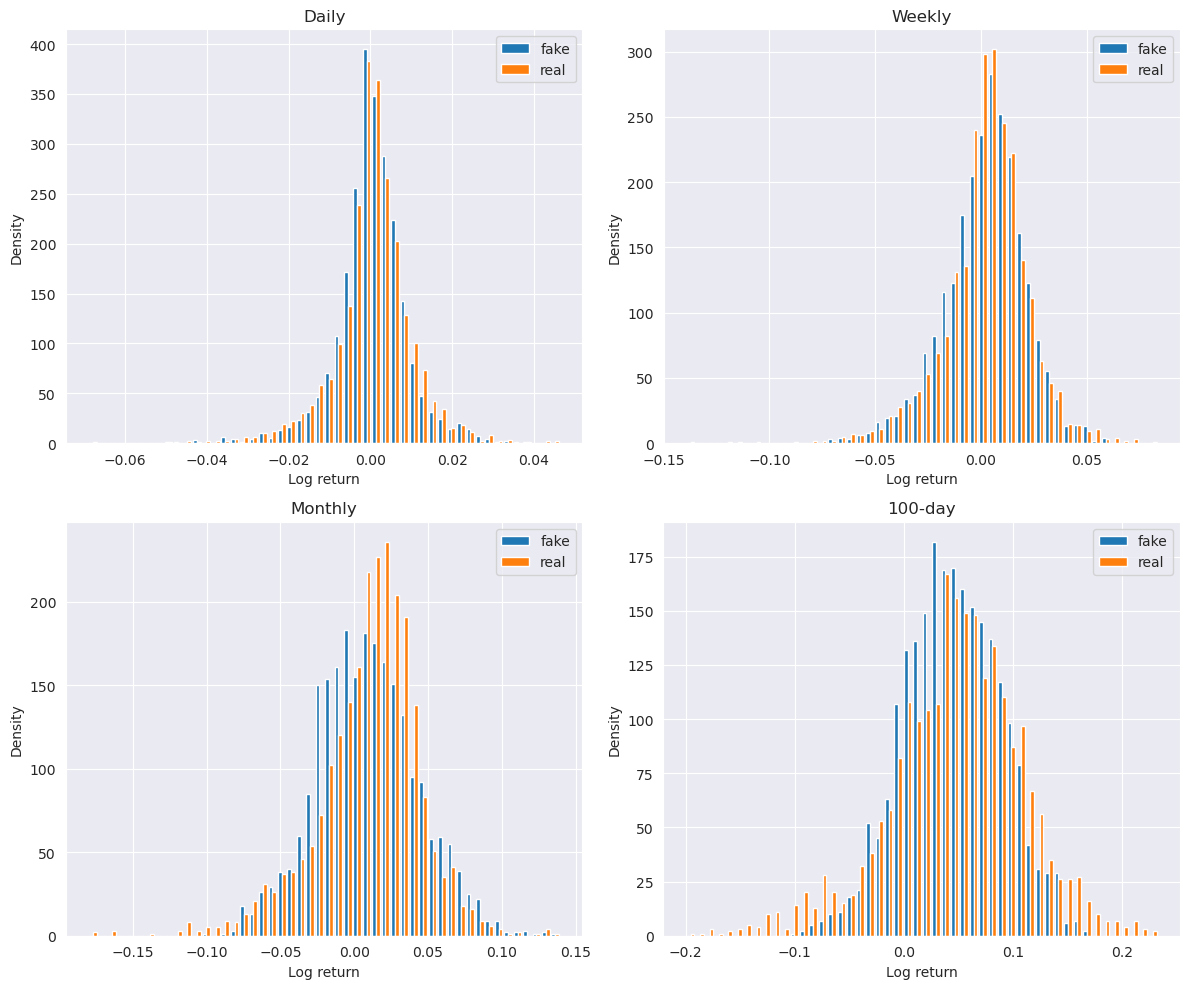

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
titles = ['Daily', 'Weekly', 'Monthly', '100-day']
diff_steps = [1, 5, 20, 100]

for ax, step, title in zip(axes.flatten(), diff_steps, titles):
    ax.hist([comp_df['fake'].diff(step), comp_df['real'].diff(step)], bins=50, label=['fake', 'real'])
    ax.set_title(title)
    ax.set_xlabel('Log return')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [17]:
acf_serial, confint_serial = sm.tsa.stattools.acf(log_returns, nlags=100, alpha=0.05)
acf_squared, confint_squared = sm.tsa.stattools.acf(log_returns**2, nlags=100, alpha=0.05)
acf_abs, confint_abs = sm.tsa.stattools.acf(np.abs(log_returns), nlags=100, alpha=0.05)
leverage_effect = log_returns.apply(compute_leverage_effect)
lags = np.arange(len(acf_serial))

In [18]:
fake = pd.DataFrame(generate_fakes(cumsum=False))

In [19]:
acf_serial_fake = sm.tsa.stattools.acf(fake, nlags=100)
acf_squared_fake = sm.tsa.stattools.acf(fake**2, nlags=100)
acf_abs_fake = sm.tsa.stattools.acf(np.abs(fake), nlags=100)
leverage_effect_fake = fake.apply(compute_leverage_effect)

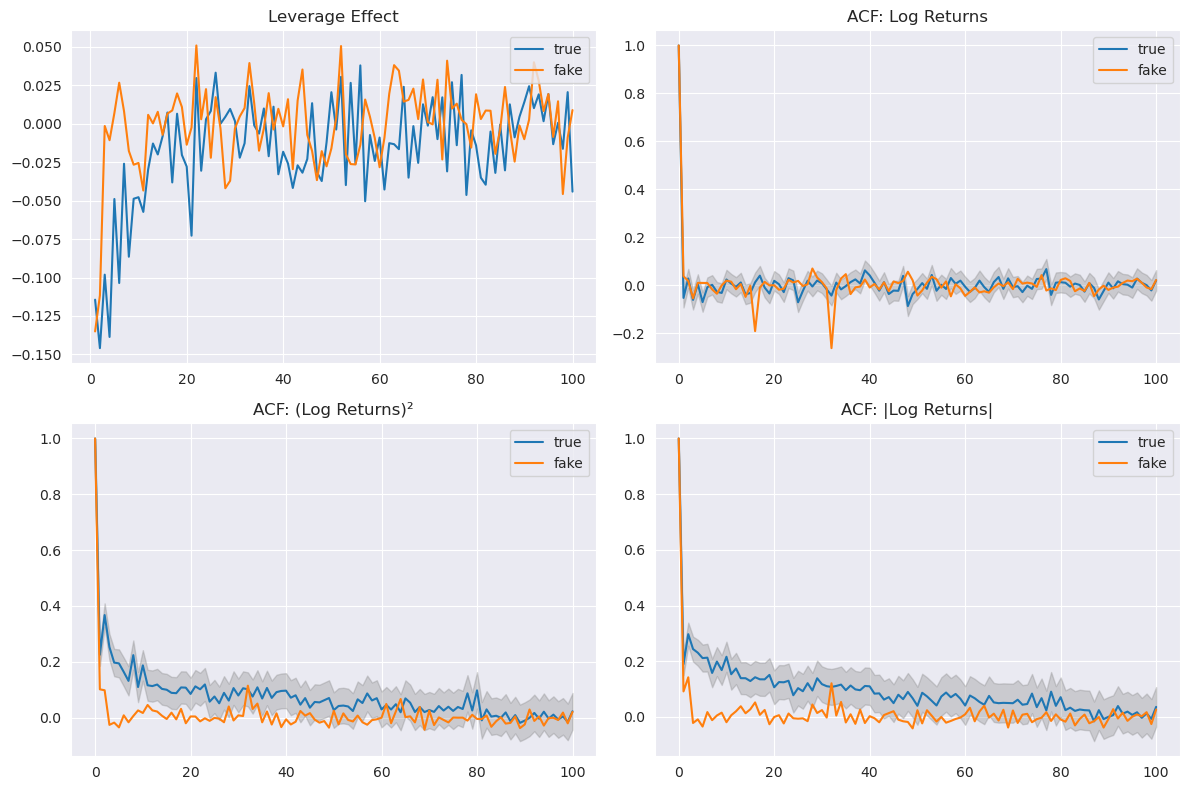

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# (1) Leverage effect
axs[0,0].plot(leverage_effect, label='true')
axs[0,0].plot(leverage_effect_fake, label='fake')
axs[0,0].set_title('Leverage Effect')
axs[0,0].grid(True)
axs[0,0].legend(loc='upper right')


# (2) ACF serial
axs[0,1].plot(lags, acf_serial, label='true')
axs[0,1].plot(lags, acf_serial_fake, label='fake')
axs[0,1].fill_between(lags, confint_serial[:,0], confint_serial[:,1], color='gray', alpha=0.3)
axs[0,1].set_title('ACF: Log Returns')
axs[0,1].grid(True)
axs[0,1].legend(loc='upper right')


# (3) ACF squared
axs[1,0].plot(lags, acf_squared, label='true')
axs[1,0].plot(lags, acf_squared_fake, label='fake')
axs[1,0].fill_between(lags, confint_squared[:,0], confint_squared[:,1], color='gray', alpha=0.3)
axs[1,0].set_title('ACF: (Log Returns)²')
axs[1,0].grid(True)
axs[1,0].legend(loc='upper right')


# (4) ACF abs
axs[1,1].plot(lags, acf_abs, label='true')
axs[1,1].plot(lags, acf_abs_fake, label='fake')
axs[1,1].fill_between(lags, confint_abs[:,0], confint_abs[:,1], color='gray', alpha=0.3)
axs[1,1].set_title('ACF: |Log Returns|')
axs[1,1].grid(True)
axs[1,1].legend(loc='upper right')

plt.tight_layout()
plt.show()
